# Análise de Retenção e Cancelamento de Planos de Saúde Pet

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = './data/Case - Estágio Analytics.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

## Data Cleaning

In [5]:
data['Data de Adesão'] = pd.to_datetime(data['Data de Adesão'], errors='coerce')
data['Valor Mensal (R$)'] = data['Valor Mensal (R$)'].str.replace(',', '.').astype(float)
data['Cancelamento'] = data['Cancelamento (Sim/Não)'].map({'Sim': 1, 'Não': 0})
data['Uso de Serviços Adicionais'] = data['Uso de Serviços Adicionais'].map({'Sim': 1, 'Não': 0})
data.drop(columns=['Cancelamento (Sim/Não)'], inplace=True)
data.dropna(subset=['Cancelamento'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()


,Cliente ID,Pet ID,Plano Atual,Data de Adesão,Número de Consultas,Uso de Serviços Adicionais,Valor Mensal (R$),Cancelamento
0,1,101,Básico,2022-01-15,5,1,150.0,0.0
1,2,102,Premium,2021-09-10,12,0,300.0,0.0
2,3,103,Avançado,2022-05-20,3,1,200.0,1.0
3,4,104,Básico,2021-11-05,8,1,150.0,0.0
4,5,105,Premium,2021-12-22,7,0,300.0,1.0


## Análise Exploratória (EDA)

### Análise de Correlação

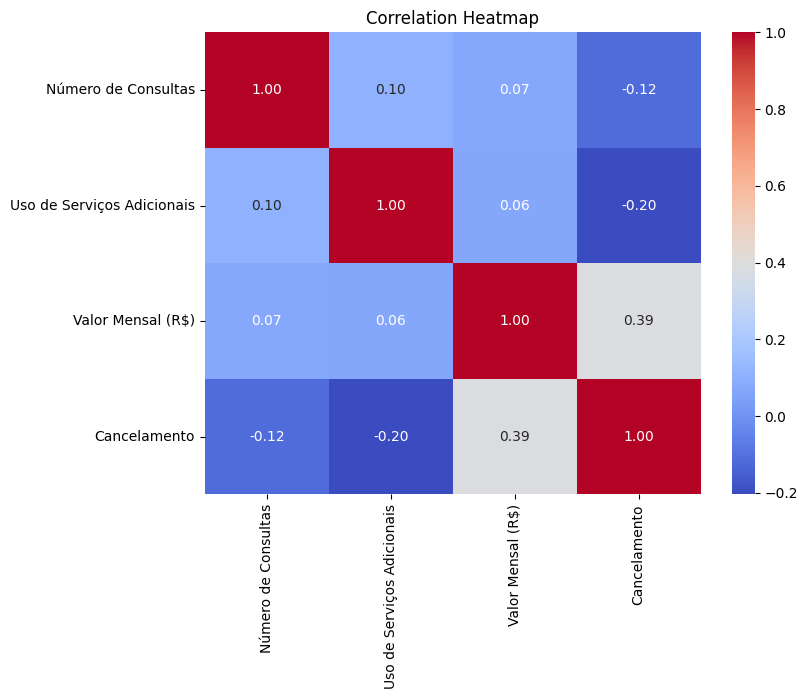

In [6]:
correlation = data[['Número de Consultas', 'Uso de Serviços Adicionais', 'Valor Mensal (R$)', 'Cancelamento']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Observações:**

- A quantidade de consultas e o uso de serviços adicionais estão negativamente correlacionados com o cancelamento, sugerindo que clientes mais engajados têm menor probabilidade de cancelar.
- Por outro lado, podemos observar que o `Valor Mensal(R$)` está positivamente correlacionado com o cancelamento, sugerindo que clientes que pagam mais têm maior probabilidade de cancelar. Iremos investigar mais a fundo.

### Tipos de Planos com Maior Taxa de Retenção


Taxa de Retenção por Tipo de Plano:
  Plano Atual  Taxa de Retenção
0    Avançado          0.714286
1      Básico          0.909091
2     Premium          0.500000


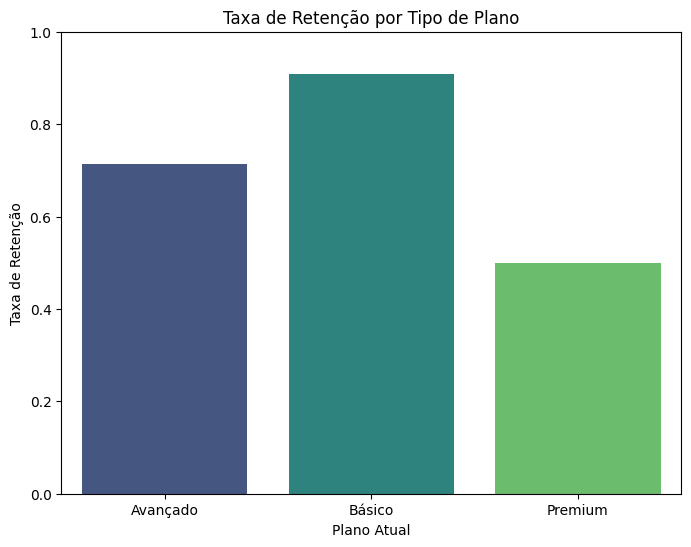

In [12]:
retention = data.groupby('Plano Atual')['Cancelamento'].mean().reset_index()
retention['Taxa de Retenção'] = 1 - retention['Cancelamento']

print("\nTaxa de Retenção por Tipo de Plano:")
print(retention[['Plano Atual', 'Taxa de Retenção']])

plt.figure(figsize=(8,6))
sns.barplot(x='Plano Atual', y='Taxa de Retenção', data=retention, palette='viridis')
plt.title('Taxa de Retenção por Tipo de Plano')
plt.ylabel('Taxa de Retenção')
plt.ylim(0,1)
plt.show()


### Cancelamento Médio x Tipo de Plano

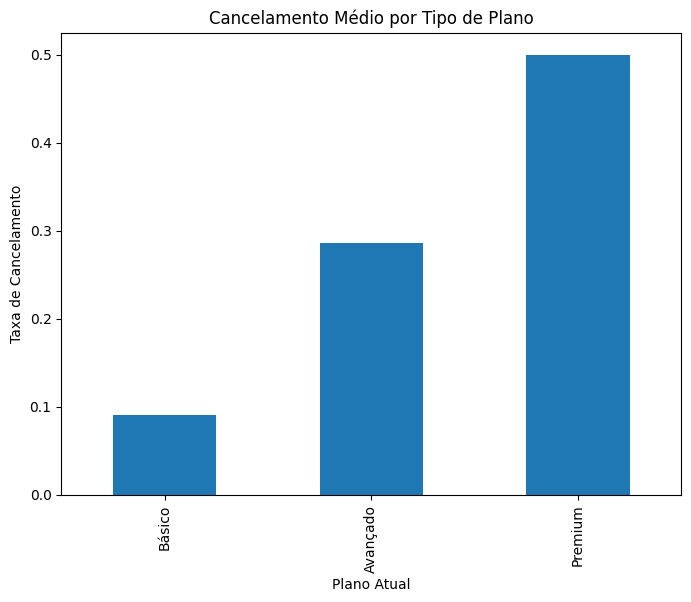

In [7]:
plan_cancellations = data.groupby('Plano Atual')['Cancelamento'].mean()

plt.figure(figsize=(8, 6))
plan_cancellations.sort_values().plot(kind='bar')
plt.title('Cancelamento Médio por Tipo de Plano')
plt.ylabel('Taxa de Cancelamento')
plt.xlabel('Plano Atual')
plt.show()

Após analisarmos os dois gráficos acima, podemos entender que o tipo de plano influencia significativamente a taxa de cancelamento.

 - É possível observar que determinados planos, os mais caros, têm maior tendência de cancelamento.

### Análise de Uso de Serviços e Cancelamentos

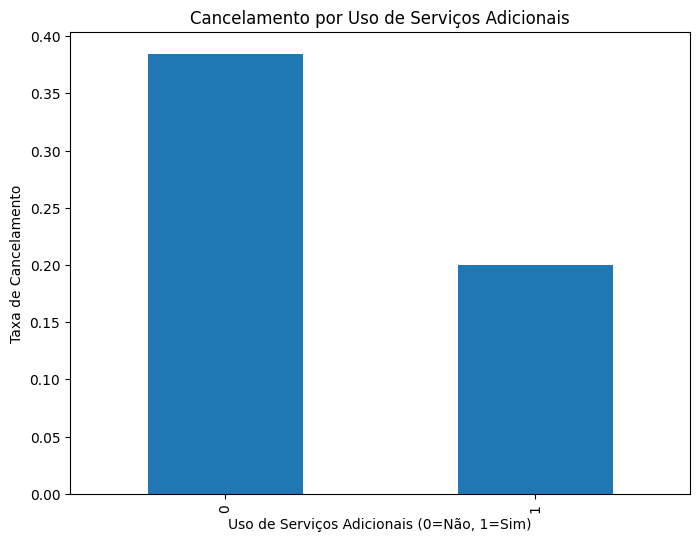

In [8]:
service_cancellation = data.groupby('Uso de Serviços Adicionais')['Cancelamento'].mean()

plt.figure(figsize=(8, 6))
service_cancellation.plot(kind='bar')
plt.title('Cancelamento por Uso de Serviços Adicionais')
plt.ylabel('Taxa de Cancelamento')
plt.xlabel('Uso de Serviços Adicionais (0=Não, 1=Sim)')
plt.show()

Clientes que utilizam serviços adicionais apresentam taxas de cancelamento mais baixas, reforçando a importância de incentivar o uso de benefícios extras.

## Retenção por Tipo de Plano

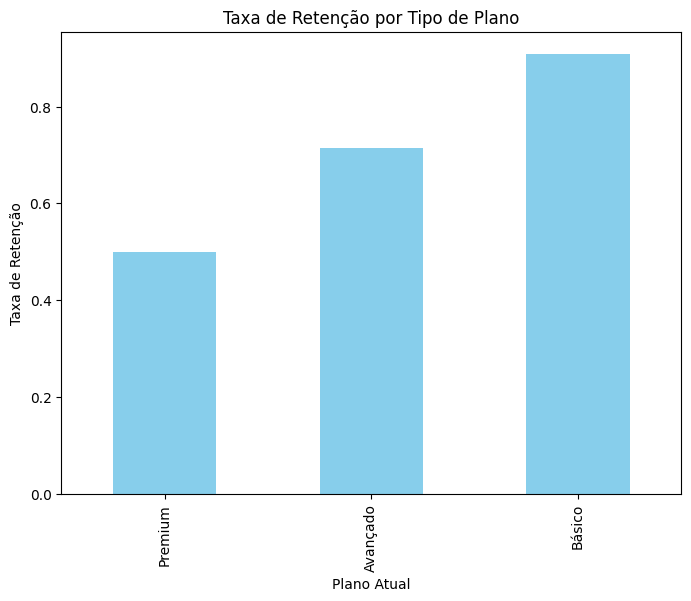

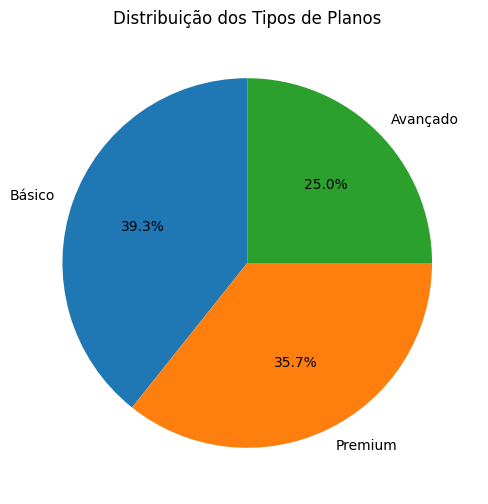

In [9]:
plan_retention = data.groupby('Plano Atual')['Cancelamento'].mean().apply(lambda x: 1 - x)

plt.figure(figsize=(8, 6))
plan_retention.sort_values().plot(kind='bar', color='skyblue')
plt.title('Taxa de Retenção por Tipo de Plano')
plt.ylabel('Taxa de Retenção')
plt.xlabel('Plano Atual')
plt.show()

plan_popularity = data['Plano Atual'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plan_popularity.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribuição dos Tipos de Planos')
plt.ylabel('')
plt.show()


Taxa de retenção:

Alguns planos apresentam taxas de retenção significativamente mais altas, indicando que são mais bem-sucedidos em manter clientes.
Planos Premium e Avançado parecem ter melhor desempenho em retenção do que o plano Básico.

Popularidade dos planos:

A distribuição de planos mostra a participação de cada tipo no total, o que ajuda a entender o impacto geral de cada plano na retenção.

### Modelagem Preditiva com Machine Learning

Para identificar os fatores mais associados ao cancelamento, treinaremos um modelo de classificação.

### Preparação dos Dados para o Modelo

In [13]:
# Seleção de features e target
X = data[['Plano Atual', 'Número de Consultas', 'Uso de Serviços Adicionais', 'Valor Mensal (R$)']]
y = data['Cancelamento']

# Codificação de variáveis categóricas
le = LabelEncoder()
X['Plano Atual'] = le.fit_transform(X['Plano Atual'])
X['Uso de Serviços Adicionais'] = le.fit_transform(X['Uso de Serviços Adicionais'])

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Padronizando as features numéricas
scaler = StandardScaler()
X_train[['Número de Consultas', 'Valor Mensal (R$)']] = scaler.fit_transform(X_train[['Número de Consultas', 'Valor Mensal (R$)']])
X_test[['Número de Consultas', 'Valor Mensal (R$)']] = scaler.transform(X_test[['Número de Consultas', 'Valor Mensal (R$)']])


### Treinamento de um Modelo de Classificação

In [14]:
# Inicializando o modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("Acurácia do Modelo:", accuracy_score(y_test, y_pred))



Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.80      0.50      0.62         8
         1.0       0.00      0.00      0.00         1

    accuracy                           0.44         9
   macro avg       0.40      0.25      0.31         9
weighted avg       0.71      0.44      0.55         9

Matriz de Confusão:
[[4 4]
 [1 0]]
Acurácia do Modelo: 0.4444444444444444


### Importância das Features


Importância das Features:
Número de Consultas           0.543372
Valor Mensal (R$)             0.190383
Plano Atual                   0.145794
Uso de Serviços Adicionais    0.120451
dtype: float64


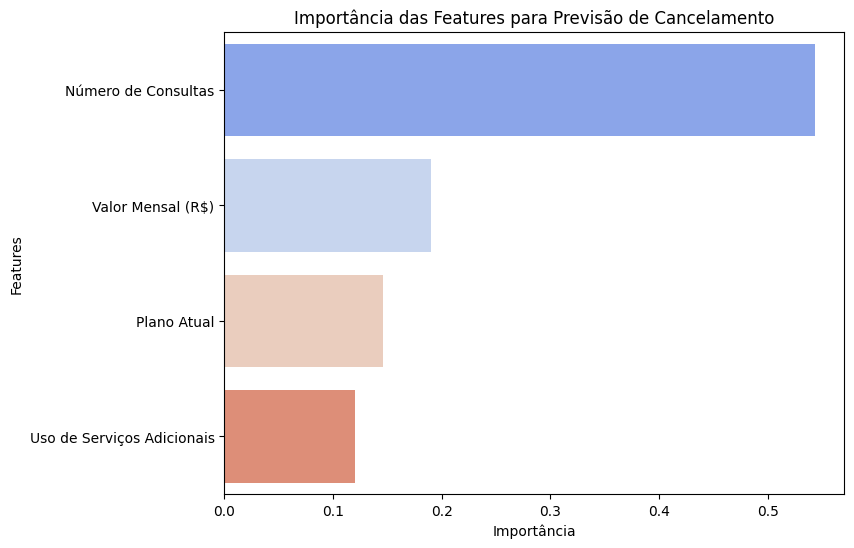

In [15]:
# Importância das features
importances = model.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("\nImportância das Features:")
print(feature_importance)

# Visualizando a importância das features
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='coolwarm')
plt.title('Importância das Features para Previsão de Cancelamento')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

# Estratégias para Reduzir a Taxa de Cancelamento e Aumentar a Adesão a Planos de Saúde Pet 🐶🐱

## **1. Reduzir a Taxa de Cancelamento**

### 🐾 **Ofereça Descontos Progressivos ou Benefícios Exclusivos**
- Crie uma campanha de fidelidade para premiar clientes que permaneçam no plano por mais tempo:
  - **6 meses:** Ofereça 1 banho gratuito.
  - **12 meses:** Inclua um check-up anual gratuito ou um desconto de 10% na renovação.
- Ofereça benefícios exclusivos para quem adere aos planos mais caros:
  - Atendimento prioritário em emergências.
  - Pacotes de vacinas incluídos.

### 🐾 **Implemente um Plano Família Pet**
- Permita que clientes incluam mais de um animal no mesmo plano com descontos cumulativos:
  - 2 pets: Aplique 15% de desconto no total.
  - 3 ou mais pets: Ofereça 20% de desconto.

### 🐾 **Envie Monitoramento Personalizado de Saúde**
- Envie notificações mensais com dicas de cuidados, alertas de vacinas, e status da saúde do pet para reforçar a percepção de valor do serviço.

### 🐾 **Facilite os Pagamentos**
- Ofereça opções de parcelamento sem juros ou descontos no pagamento anual.
- Disponibilize planos com franquias ajustáveis para quem deseja pagar menos mensalmente.

### 🐾 **Crie um Programa de Indicação**
- Ofereça recompensas para clientes que indicarem novos membros:
  - Para cada amigo indicado que aderir ao plano, dê um mês grátis ou um desconto no próximo pagamento.

## **2. Aumentar a Adesão a Novos Planos**

### 🐾 **Lance Campanhas Promocionais**
- Ofereça um desconto de boas-vindas para novos clientes nos primeiros 3 meses.
- Inclua um presente no momento da adesão, como:
  - Brinquedos para pets.
  - Kits de higiene (escova, shampoo, etc.).
  - Ração inicial de alta qualidade.

### 🐾 **Crie Pacotes Personalizados**
- Disponibilize planos ajustáveis com base no perfil do pet:
  - **Filhotes:** Inclua vacinação completa, castração, e acompanhamento veterinário inicial.
  - **Pets Sênior:** Insira exames preventivos, consultas geriátricas, e suporte para doenças crônicas.

### 🐾 **Estabeleça Parcerias Estratégicas**
- Faça parcerias com pet shops, hotéis para pets, e clínicas veterinárias para oferecer descontos cruzados:
  - Ao contratar um plano, ofereça um voucher para banho/tosa ou descontos em produtos da loja parceira.

### 🐾 **Produza Conteúdo Educativo**
- Crie vídeos e artigos sobre a importância de consultas preventivas, vacinação e nutrição.
- Compartilhe histórias de sucesso de pets que se beneficiaram dos planos.

### 🐾 **Ofereça Test Drives de Serviços**
- Disponibilize um período experimental com benefícios limitados para que novos clientes conheçam o plano antes de aderirem oficialmente.

### 🐾 **Marque Presença em Eventos Pet**
- Participe de feiras e eventos locais e promova os planos com stands interativos:
  - Realize sorteios de brindes.
  - Ofereça descontos exclusivos para quem aderir no evento.


# Utilização de Insights para Personalizar Ofertas para Diferentes Segmentos de Clientes 🐶🐱

## **1. Identifique Segmentos de Clientes**
- **Agrupe os clientes com base em características comuns**, como:
  - **Tipo de animal**: Cães, gatos ou outros pets.
  - **Faixa etária do pet**: Filhotes, adultos e idosos.
  - **Perfil de gastos**: Clientes que optam por planos básicos, intermediários ou premium.
  - **Motivações de cancelamento**: Preço, falta de uso ou insatisfação.

## **2. Crie Ofertas Baseadas nos Segmentos**
- **Para donos de filhotes**:
  - Ofereça planos com vacinação completa, castração e kits de higiene inicial.
  - Destaque benefícios que ajudam no desenvolvimento saudável do pet.
- **Para donos de pets idosos**:
  - Personalize planos com exames preventivos, consultas geriátricas e suporte para condições crônicas.
- **Para clientes preocupados com custos**:
  - Proponha planos básicos com opções de upgrades progressivos.
  - Envie ofertas promocionais, como descontos temporários ou parcelamento sem juros.

## **3. Utilize Dados para Comunicação Personalizada**
- **Ajuste a comunicação com base nos insights**:
  - Envie e-mails ou mensagens segmentadas com conteúdos relevantes para cada tipo de cliente.
  - Utilize dados sobre consultas frequentes ou históricos de uso para lembrar o cliente de serviços inclusos no plano.
- **Exemplo de personalização**:
  - Para clientes que raramente utilizam o plano, envie lembretes sobre serviços disponíveis, como banho ou vacinação.
  - Para clientes que utilizam o plano regularmente, ofereça upgrades para planos superiores com benefícios adicionais.

## **4. Ofereça Benefícios Relevantes**
- **Combine os dados de uso com ofertas estratégicas**:
  - Se o cliente tem múltiplos pets, sugira o Plano Família com descontos cumulativos.
  - Se o cliente cancelou por insatisfação com o valor, envie uma proposta promocional de reativação com descontos.

## **5. Incentive a Fidelidade**
- **Crie programas que recompensem a lealdade**:
  - Ofereça vantagens progressivas com o tempo, como serviços adicionais (banhos, consultas extras).
  - Use insights sobre o tempo de permanência no plano para personalizar as recompensas.

Com essas estratégias, a empresa pode transformar insights em ações práticas, entregando valor real para os clientes e aumentando tanto a adesão quanto a fidelidade aos planos.